# Particle movement by Piotr Pogwizd

In [1]:
import cython 
%load_ext cython

In [2]:
%%cython -a 
from IPython import display
cimport cython 
import numpy as np 
cimport numpy as np
from cython.parallel cimport prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef void propagateParticleV2(
    double[:,:] x, double[:,:] y, double[:,:] Vx, double[:,:] Vy, double[:,:] V,
    double[:,:] Vw, double Vw0,
    double[:,:] D, double[:,:] Dw, double[:,:] a_x, double[:,:] a_y, double[:,:] a_w,
    int iterator, double dt, double a, double b, int nPx, int nPy, double m, double r, double Wariant):
    
    ###########################
    cdef int i,j
    cdef double Cd = 0.47
    cdef double p = 1.2
    cdef double ds_x
    cdef double ds_y
    ###########################
    
    # The loop defining the position matrix X and the velocity Vx reduced by a_x and a_w:
    ###############################################################################
    if Wariant == 1:
        for i in prange(nPx, nogil=True):
            ds_x = Vx[iterator, i] * dt

            if 0 < x[iterator, i] + ds_x and x[iterator, i] + ds_x < a:
                x[iterator+1,i] = x[iterator, i] + ds_x
            elif x[iterator,i] + ds_x >= a:
                x[iterator+1, i] = a - (x[iterator, i]  - ds_x)
            else:
                x[iterator+1,i] = a - (ds_x - x[iterator,i])

            Vx[iterator+1,i] = Vx[iterator,i] - dt*a_x[iterator,i] - dt*a_w[iterator,i]
    if Wariant == 0:
        for i in prange(nPx, nogil=True):
            ds_x = Vx[iterator, i] * dt

            if 0 < x[iterator, i] + ds_x and x[iterator, i] + ds_x < a:
                x[iterator+1,i] = x[iterator, i] + ds_x
                Vx[iterator+1,i] = Vx[iterator,i] - dt*a_x[iterator,i] - dt*a_w[iterator,i]
            elif x[iterator,i] + ds_x >= a:
                x[iterator+1, i] = a - (x[iterator, i]  - ds_x)
                Vx[iterator+1,i] = Vx[iterator,i] - dt*a_x[iterator,i] - dt*a_w[iterator,i]
            else:
                x[iterator+1, i] = - ds_x - x[iterator, i]
                Vx[iterator+1,i] = (-1) * (Vx[iterator,i] - dt*a_x[iterator,i])
    ###############################################################################
    
    
    # The loop defining the position matrix Y and the velocity Vy reduced by a_y:
    ###############################################################################
    for j in prange(nPy, nogil=True):
        ds_y = Vy[iterator, j] * dt  
        
        if 0 < y[iterator, j] + ds_y and y[iterator, j] + ds_y < b:
            y[iterator+1,j] = y[iterator,j] + ds_y
            Vy[iterator+1,j] = Vy[iterator,j] - dt*a_y[iterator,j]
        elif y[iterator, j] + ds_y >= b:
            y[iterator+1, j] = b - (ds_y - (b - y[iterator, j])) 
            Vy[iterator+1,j] = (-1) * (Vy[iterator,j] - dt*a_y[iterator,j])
        else:
            y[iterator+1, j] = - ds_y - y[iterator, j]
            Vy[iterator+1,j] = (-1) * (Vy[iterator,j] - dt*a_y[iterator,j])
    ###############################################################################
    
    
    # Determining new accelerations a_x, a_y, a_w for the new speed V:
    ##############################################################################################################
    for i in range(nPy):
        Vw[iterator + 1,i] = Vw0 * np.sin(np.pi * y[iterator + 1,i])
    
    for i in range(nPx):
        V[iterator + 1,i] = np.sqrt((Vx[iterator + 1,i])**2 + (Vy[iterator + 1,i])**2)
        D[iterator + 1,i] = Cd*p*(np.pi*r**2)*(V[iterator + 1,i]**2)/2
        Dw[iterator + 1,i] = Cd*p*(np.pi*r**2)*(Vw[iterator + 1,i]**2)/2
        a_x[iterator + 1,i] = (D[iterator + 1,i])*(Vx[iterator + 1,i]/V[iterator + 1,i])/m
        a_w[iterator + 1,i] = -(Dw[iterator + 1,i])*((Vw[iterator + 1,i] - Vx[iterator + 1,i])/V[iterator + 1,i])/m
        
    for i in range(nPy):
        a_y[iterator + 1,i] = (D[iterator + 1,i])*(Vy[iterator + 1,i]/V[iterator + 1,i])/m
    ##############################################################################################################
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cpdef solveParticleMovement2(double[:] X0, double[:] Y0, double[:] Vx0, double[:] Vy0,
                             double Vw0, double dT, double T, double a, double b, double m, double r, double Wariant):

    # Additional required variables and constants:
    #########################################################################
    cdef int l
    cdef int iterator = 0 
    cdef double Cd = 0.47    # Resistance coefficient (for a ball it is 0.47)
    cdef double p = 1.2      # The density of the fluid (for air is 1.2)
    cdef int numOfTimeSteps = int(T/dT) + 1
    cdef int nPart_x = X0.shape[0]            
    cdef int nPart_y = Y0.shape[0]  
    #########################################################################
    
    
    # Matrix definition:
    #########################################################################
    cdef double[:,:] X = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double)  # Matrix of positions X
    cdef double[:,:] Y = np.zeros((numOfTimeSteps,nPart_y), dtype=np.double)  # Matrix of positions Y
    cdef double[:,:] Vx = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double) # x component speed
    cdef double[:,:] Vy = np.zeros((numOfTimeSteps,nPart_y), dtype=np.double) # y component speed
    cdef double[:,:] V = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double)  # The particle velocity is determined from the component velocities Vx and Vy
    cdef double[:,:] Vw = np.zeros((numOfTimeSteps,nPart_y), dtype=np.double) # Wind speed (different for each y)
    cdef double[:,:] D = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double)  # Resistance due to particle velocity
    cdef double[:,:] Dw = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double) # Air resistance due to particle velocity 
    cdef double[:,:] a_x = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double) # The acceleration resulting from D and Vx
    cdef double[:,:] a_y = np.zeros((numOfTimeSteps,nPart_y), dtype=np.double) # The acceleration resulting from D and Vy
    cdef double[:,:] a_w = np.zeros((numOfTimeSteps,nPart_x), dtype=np.double) # The acceleration resulting from Dw, Vx amd Vw
    #########################################################################
    
    
    # Initial conditions:
    #########################################################################
    X.base[0,:] = X0
    Y.base[0,:] = Y0
    Vx.base[0,:] = Vx0
    Vy.base[0,:] = Vy0
    for l in range(nPart_y):
        Vw[iterator,l] = Vw0 * np.sin(np.pi * Y[iterator,l])
    for l in range(nPart_x):
        V[iterator,l] = np.sqrt((Vx[iterator,l])**2 + (Vy[iterator,l])**2)
        D[iterator,l] = Cd*p*(np.pi*r**2)*(V[iterator,l]**2)/2
        Dw[iterator,l] = Cd*p*(np.pi*r**2)*(Vw[iterator,l]**2)/2
        a_x[iterator,l] = (D[iterator,l])*(Vx[iterator,l]/V[iterator,l])/m
        a_w[iterator,l] = (Dw[iterator,l])*((Vw[iterator,l] - Vx[iterator,l])/V[iterator,l])/m
        
    for l in range(nPart_y):
        a_y[iterator,l] = (D[iterator,l])*(Vy[iterator,l]/V[iterator,l])/m
    #########################################################################

    # Loop that counts the required values in successive time steps:
    #########################################################################
    while (iterator+1)*dT < T:            
            
        propagateParticleV2(X, Y, Vx, Vy, V, Vw, Vw0, D, Dw, a_x, a_y, a_w, iterator, dT, a, b, nPart_x, nPart_y, m, r, Wariant)
        
        iterator += 1
        
    return X.base, Y.base, Vx.base, Vy.base, V.base, Vw.base, D.base, Dw.base, a_x.base, a_y.base, a_w.base
    #########################################################################

# Large amount of particles - test:

In [3]:
T_ = 50
dT_ = 0.1
a_ = 1
b_ = 1
nParticles_ = 1000

X0_ = np.random.rand(nParticles_)
Y0_ = np.random.rand(nParticles_)

Vx0_ = np.zeros(nParticles_)
Vy0_ = np.zeros(nParticles_)
for i in range(nParticles_):
    Vx0_[i] = np.random.uniform(-1, 1)
    Vy0_[i] = np.random.uniform(-1, 1)


Vw0_ = 0.5
m_ = 1
r_ = 1

X_, Y_, Vx_, Vy_, V_, Vw_, D_, Dw_, a_x_, a_y_, a_w_ = solveParticleMovement2(X0_, Y0_, Vx0_, Vy0_, Vw0_, dT_, T_, a_, b_, m_, r_, 1)



In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from jupyterthemes import jtplot
from matplotlib import rcParams
rcParams['axes.labelpad'] = 20
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Avg_X_ = np.zeros(X_.shape[0] - 1)
Avg_Y_ = np.zeros(Y_.shape[0] - 1)

Avg_Vx_ = np.zeros(Vx_.shape[0] - 1)
Avg_Vy_ = np.zeros(Vx_.shape[0] - 1)

for i in range(X_.shape[0] - 1):
    Avg_X_[i] = sum(X_[i,:])/len(X_[i,:])

for i in range(Y_.shape[0] - 1):
    Avg_Y_[i] = sum(Y_[i,:])/len(Y_[i,:])
    
for i in range(Vx_.shape[0] - 1):
    Avg_Vx_[i] = sum(Vx_[i,:])/len(Vx_[i,:])

for i in range(Vy_.shape[0] - 1):
    Avg_Vy_[i] = sum(Vy_[i,:])/len(Vy_[i,:])
    
avx = np.linspace(1, X_.shape[0] - 1, X_.shape[0] - 1)

### Average position of x and y coordinates over time

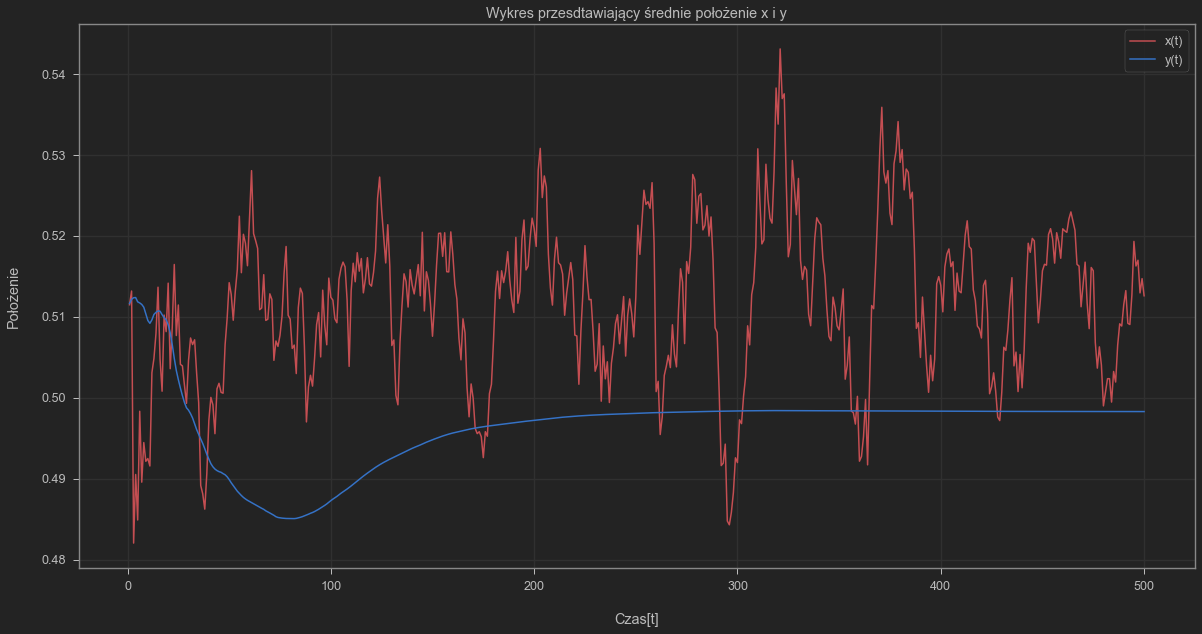

In [5]:
plt.figure(figsize=(20,10))
plt.plot(avx, Avg_X_, "r", avx, Avg_Y_, "b")
plt.xlabel("Czas[t]")
plt.ylabel("Położenie")
plt.title("Wykres przesdtawiający średnie położenie x i y")
plt.grid(True)
plt.legend(["x(t)","y(t)"])
plt.show()

### Average velocities of Vx and Vy over time

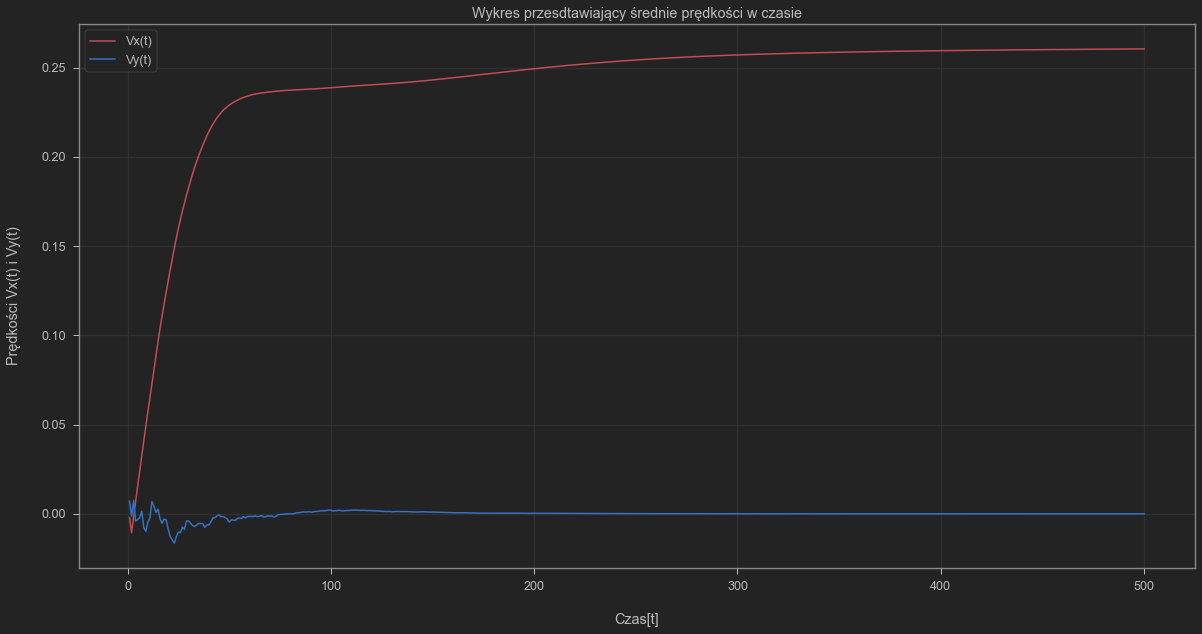

In [6]:
plt.figure(figsize=(20,10))
plt.plot(avx, Avg_Vx_, "r", avx, Avg_Vy_, "b")
plt.xlabel("Czas[t]")
plt.ylabel("Prędkości Vx(t) i Vy(t)")
plt.title("Wykres przesdtawiający średnie prędkości w czasie")
plt.grid(True)
plt.legend(["Vx(t)", "Vy(t)"])
plt.show()

# Animation for a small amount of particles:

In [ ]:
nParticles = int(input("Ilość cząstek: "))
T = int(input("Ilość kroków czasowych: "))
Vw0 = float(input("Prędkość wiatru(przedział (-100,100)): "))
Wariant = int(input("Lewa ściana = Prawa ściana [Wybierz 1] | Lewa ściana zamknięta [Wybierz 0]: "))
a = 4
b = 1
dT = 0.1
X0 = np.zeros(nParticles)
Y0 = np.zeros(nParticles)
for i in range(nParticles):
    X0[i] = np.random.uniform(0, 1*a/10)
    Y0[i] = np.random.uniform(0, b)

Vx0 = np.zeros(nParticles)
Vy0 = np.zeros(nParticles)
for i in range(nParticles):
    Vx0[i] = np.random.uniform(0, 0.8)
    Vy0[i] = np.random.uniform(0, 0.1)
m = 1
r = 1

X, Y, Vx, Vy, V, Vw, D, Dw, a_x, a_y, a_w = solveParticleMovement2(X0, Y0, Vx0, Vy0, Vw0/100, dT, T, a, b, m, r, Wariant)

Ilość cząstek: 200
Ilość kroków czasowych: 1000
Prędkość wiatru(przedział (-100,100)): 10


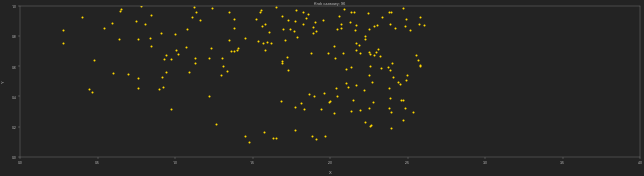

In [14]:
    for t in range(T):
        if ((t % 4) == 0) or (t == T):
            fig = plt.figure(figsize=(int(a*10),int(b*10)), dpi=20)
            ax = plt.axes(xlim=(0, a), ylim=(0, b))
            ax.scatter(X[t,:],Y[t,:], color="gold") 
            plt.xlabel("X")
            plt.ylabel("Y")
            ax.set_title("Krok czasowy: " + str(t))
            display.clear_output(wait=True)
            plt.pause(0.00001)

In [ ]:
# %matplotlib inline
# import numpy as np
# from IPython.display import HTML
# from matplotlib import pyplot as plt
# import matplotlib
# import matplotlib.cm as cm
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter

# plt.style.use('seaborn-pastel')
# matplotlib.rcParams['animation.writer'] = 'ffmpeg'

# fig = plt.figure(figsize = (10,10))
# ax = plt.axes(xlim=(0, a), ylim=(-1, 1))
# cmap = cm.get_cmap(name='rainbow')


# index = np.arange(nParticles)/nParticles

# def init():
#     line = ax.scatter([], [], lw=3)
#     return line,
# def animate(i):
#     x = X[i,:]
#     y = Y[i,:]
#     ax.clear() 
#     ax.set_xlim(left=0,right=a)
#     ax.set_ylim(bottom=0,top=a)
#     titleStr = ("Time: " + str(np.round(i * dT,2))) 
#     ax.set_title(titleStr)
#     line = ax.scatter(x,y, color=cmap(index)) 
#     return line,

# anim = FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=150, blit=True)

# writer = PillowWriter(fps=20)
# anim.save("savedGif.gif", writer=writer)

# HTML(anim.to_html5_video())